# HybridMedNet - 医学影像深度学习诊断框架



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alltobebetter/HybridMedNet/blob/main/HybridMedNet_Colab.ipynb)

一键运行医学影像分类训练

## 1. 环境设置

In [ ]:
# 检查 GPU
!nvidia-smi

import torch
print(f"\nPyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Fri Oct 31 07:27:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 克隆项目
import os
if not os.path.exists('HybridMedNet'):
    !git clone https://github.com/alltobebetter/HybridMedNet.git
    print("[OK] 项目克隆完成")
else:
    print("[OK] 项目已存在")

%cd HybridMedNet

Cloning into 'HybridMedNet'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 83 (delta 23), reused 75 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 99.32 KiB | 6.21 MiB/s, done.
Resolving deltas: 100% (23/23), done.
[OK] 项目克隆完成
/content/HybridMedNet


## 2. 安装依赖

In [ ]:
!pip install -q timm albumentations einops
!pip install -q pandas matplotlib seaborn scikit-learn tqdm
print("[OK] 依赖安装完成")

[OK] 依赖安装完成


## 3. 选择数据集

### 选项 A: 使用示例数据（快速测试）
### 选项 B: 下载真实医学数据集（推荐）

In [ ]:
# 选择数据集类型
USE_REAL_DATASET = True  # True=真实数据集, False=示例数据

if USE_REAL_DATASET:
    print("将使用真实医学数据集")
else:
    print("将使用示例数据集（快速测试）")

将使用真实医学数据集


### 下载真实数据集：胸部 X 光肺炎数据集

- 数据集: Chest X-Ray Pneumonia
- 大小: ~1.2 GB
- 图像数: 5,863 张
- 类别: Normal / Pneumonia
- 来源: Kaggle

**如何获取 Kaggle API key:**
1. 访问 https://www.kaggle.com/settings
2. 点击 'Create New API Token'
3. 下载 kaggle.json
4. 运行下面的 cell 上传文件

In [ ]:
# 上传 Kaggle API key
if USE_REAL_DATASET:
    import os
    if not os.path.exists("/root/.kaggle/kaggle.json"):
        print("请上传 kaggle.json 文件")
        from google.colab import files
        uploaded = files.upload()
        
        if "kaggle.json" in uploaded:
            !mkdir -p ~/.kaggle
            !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            print("[OK] Kaggle API key 已配置")
    else:
        print("[OK] Kaggle API key 已存在")

In [ ]:
if USE_REAL_DATASET:
    print("正在下载真实数据集...")
    print("这可能需要 5-10 分钟，请耐心等待\n")

    import os

    # 检查是否有 kaggle.json
    if os.path.exists('/root/.kaggle/kaggle.json'):
        print("使用 Kaggle API 下载...\n")
        !pip install -q kaggle
        !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

        print("\n解压数据集...")
        !unzip -q chest-xray-pneumonia.zip -d ./data/
        !rm chest-xray-pneumonia.zip

        # 查找数据目录
        if os.path.exists('./data/chest_xray/train'):
            data_dir = './data/chest_xray/train'
        elif os.path.exists('./data/train'):
            data_dir = './data/train'
        else:
            print("[WARNING] 未找到训练数据目录")
            data_dir = None

        if data_dir:
            print(f"\n[OK] 数据集下载完成")
            print(f"数据位置: {data_dir}")
            !ls -lh {data_dir}
            labels_file = None
        else:
            print("\n[INFO] 下载失败，将使用示例数据")
            data_dir = None
            labels_file = None
    else:
        print("[WARNING] 未检测到 Kaggle API key")
        print("请先运行上面的 cell 上传 kaggle.json")
        print("或者设置 USE_REAL_DATASET = False 使用示例数据\n")
        data_dir = None
        labels_file = None

else:
    print("跳过真实数据集下载")
    data_dir = None
    labels_file = None

正在下载真实数据集...
这可能需要 5-10 分钟，请耐心等待

使用 Kaggle API 下载...

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:37<00:01, 29.7MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.8MB/s]

解压数据集...

[OK] 数据集下载完成
数据位置: ./data/chest_xray/train
total 276K
drwxr-xr-x 2 root root  68K Oct 31 07:29 NORMAL
drwxr-xr-x 2 root root 208K Oct 31 07:29 PNEUMONIA


## 4. 准备数据和配置

In [ ]:
# 导入必要模块
import sys
sys.path.insert(0, os.getcwd())

from data.chest_xray_dataset import create_sample_dataset, ChestXrayDataset
from data.transforms import get_train_transforms, get_val_transforms
from models.hybrid_med_net import HybridMedNet
from configs.default_config import Config
from utils.metrics import calculate_metrics

print("[OK] 模块导入成功")

[OK] 模块导入成功


In [ ]:
# 如果没有使用真实数据集，创建示例数据
if not USE_REAL_DATASET or data_dir is None:
    print("创建示例数据集...")
    data_dir = './data/sample_chest_xray'
    data_dir, labels_file = create_sample_dataset(data_dir, num_samples=200)
    print(f"[OK] 示例数据集创建完成: {data_dir}")
else:
    print(f"[OK] 使用真实数据集: {data_dir}")

[OK] 使用真实数据集: ./data/chest_xray/train


In [ ]:
# 配置模型
config = Config()
config.DATA['data_dir'] = data_dir
config.DATA['labels_file'] = labels_file
config.DATA['num_workers'] = 2
config.MODEL['hierarchical'] = False

# 根据数据集类型调整配置
if USE_REAL_DATASET:
    # 真实数据集优化配置
    config.TRAIN['batch_size'] = 32
    config.TRAIN['epochs'] = 20
    config.TRAIN['learning_rate'] = 1e-4
    config.TRAIN['weight_decay'] = 1e-3
    config.MODEL['backbone'] = 'resnet50'
    config.MODEL['num_classes'] = 2
    config.MODEL['dropout'] = 0.7
    print("使用真实数据集优化配置")
else:
    # 示例数据配置
    config.TRAIN['batch_size'] = 16
    config.TRAIN['epochs'] = 10
    config.TRAIN['learning_rate'] = 1e-4
    config.MODEL['backbone'] = 'resnet50'
    config.MODEL['num_classes'] = 14
    print("使用示例数据配置")

config.TRAIN['mixed_precision'] = True

print("\n配置信息:")
print(f"  数据目录: {config.DATA['data_dir']}")
print(f"  类别数: {config.MODEL['num_classes']}")
print(f"  Backbone: {config.MODEL['backbone']}")
print(f"  Batch size: {config.TRAIN['batch_size']}")
print(f"  Epochs: {config.TRAIN['epochs']}")
print(f"  Learning rate: {config.TRAIN['learning_rate']}")
print(f"  Weight decay: {config.TRAIN['weight_decay']}")
print(f"  Dropout: {config.MODEL.get('dropout', 0.5)}")

使用真实数据集优化配置（修复版）

配置信息:
  数据目录: ./data/chest_xray/train
  类别数: 2
  Backbone: resnet50
  Batch size: 32
  Epochs: 20
  Learning rate: 0.0001
  Weight decay: 0.001
  Dropout: 0.7


## 5. 加载数据

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm.notebook import tqdm
import numpy as np
import os

print("="*60)
print("加载数据集")
print("="*60)

# 根据数据集类型选择加载方式
if USE_REAL_DATASET and labels_file is None:
    # 使用 ImageFolder 加载文件夹结构的数据
    print("\n使用文件夹结构加载真实数据集...")
    print(f"训练集路径: {config.DATA['data_dir']}")

    train_dataset = datasets.ImageFolder(
        root=config.DATA['data_dir'],
        transform=get_train_transforms(config.DATA['image_size'])
    )

    # 使用测试集作为验证集（测试集通常比 val 更大）
    val_dir = config.DATA['data_dir'].replace('train', 'test')
    if not os.path.exists(val_dir):
        val_dir = config.DATA['data_dir'].replace('train', 'val')

    print(f"验证集路径: {val_dir}")

    val_dataset = datasets.ImageFolder(
        root=val_dir,
        transform=get_val_transforms(config.DATA['image_size'])
    )

    print(f"\n✓ 数据加载成功")
    print(f"  类别: {train_dataset.classes}")
    print(f"  训练集: {len(train_dataset)} 张")
    print(f"  验证集: {len(val_dataset)} 张")

    # 检查验证集大小
    if len(val_dataset) < 200:
        print(f"  ⚠️  警告: 验证集较小（{len(val_dataset)} 张），可能导致 loss 波动")

else:
    # 使用 CSV 标签文件加载
    print("\n使用 CSV 标签文件加载数据...")
    print(f"数据目录: {config.DATA['data_dir']}")
    print(f"标签文件: {config.DATA['labels_file']}")

    train_dataset = ChestXrayDataset(
        data_dir=config.DATA['data_dir'],
        labels_file=config.DATA['labels_file'],
        transform=get_train_transforms(config.DATA['image_size']),
        split='train'
    )

    val_dataset = ChestXrayDataset(
        data_dir=config.DATA['data_dir'],
        labels_file=config.DATA['labels_file'],
        transform=get_val_transforms(config.DATA['image_size']),
        split='val'
    )

    print(f"\n✓ 数据加载成功")

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=config.TRAIN['batch_size'],
    shuffle=True,
    num_workers=config.DATA['num_workers']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.TRAIN['batch_size'],
    shuffle=False,
    num_workers=config.DATA['num_workers']
)

print("\n" + "="*60)
print("数据加载完成")
print("="*60)
print(f"训练集: {len(train_dataset)} 张")
print(f"验证集: {len(val_dataset)} 张")
print(f"Batch size: {config.TRAIN['batch_size']}")
print(f"训练 batches: {len(train_loader)}")
print(f"验证 batches: {len(val_loader)}")

加载数据集

使用文件夹结构加载真实数据集...
训练集路径: ./data/chest_xray/train
验证集路径: ./data/chest_xray/test

✓ 数据加载成功
  类别: ['NORMAL', 'PNEUMONIA']
  训练集: 5216 张
  验证集: 624 张

数据加载完成
训练集: 5216 张
验证集: 624 张
Batch size: 32
训练 batches: 163
验证 batches: 20


## 6. 训练模型

In [ ]:
# 创建模型（添加优化技术）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridMedNet(config).to(device)

# 损失函数和优化器
if USE_REAL_DATASET and config.MODEL['num_classes'] == 2:
    # 单标签分类 - 添加类别权重处理不平衡
    class_weights = torch.tensor([1.5, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    is_multilabel = False
    print("使用单标签分类 + 类别权重")
else:
    # 多标签分类（BCE）
    criterion = nn.BCEWithLogitsLoss()
    is_multilabel = True
    print("使用多标签分类")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.TRAIN['learning_rate'],
    weight_decay=config.TRAIN['weight_decay']
)

# 学习率调度器
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

print(f"\n[OK] 模型已创建")
print(f"设备: {device}")
print(f"分类类型: {'多标签' if is_multilabel else '单标签'}")
print(f"优化技术: 学习率调度 + 梯度裁剪 + 早停")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 90.0MB/s]


使用单标签分类 + 类别权重

[OK] 模型已创建
设备: cuda
分类类型: 单标签
优化技术: 学习率调度 + 梯度裁剪 + 早停


In [ ]:
# 训练循环（优化版）
best_val_loss = float('inf')
train_losses = []
val_losses = []
patience_counter = 0
early_stopping_patience = 3

print("\n开始训练...\n")


for epoch in range(config.TRAIN['epochs']):
    # 训练阶段
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.TRAIN['epochs']} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 验证阶段
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.TRAIN['epochs']} [Val]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # 学习率调度
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, LR = {current_lr:.2e}")

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  -> 保存最佳模型 (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"\n早停触发！{early_stopping_patience} 轮未改善，停止训练。")
            print(f"最佳 Val Loss: {best_val_loss:.4f}")
            break

print("\n[OK] 训练完成")
print(f"最佳模型: Epoch {train_losses.index(min(train_losses))+1}, Val Loss = {best_val_loss:.4f}")


开始训练...

优化技术:
  - 梯度裁剪（防止梯度爆炸）
  - 学习率调度（自动降低学习率）
  - 早停（防止过拟合）
  - 类别权重（处理数据不平衡）



Epoch 1/20 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.2147, Val Loss = 0.2750, LR = 1.00e-04
  -> 保存最佳模型 (Val Loss: 0.2750)


Epoch 2/20 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1052, Val Loss = 0.3540, LR = 1.00e-04


Epoch 3/20 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.0919, Val Loss = 0.5491, LR = 1.00e-04


Epoch 4/20 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.0701, Val Loss = 0.8678, LR = 1.00e-04

早停触发！3 轮未改善，停止训练。
最佳 Val Loss: 0.2750

[OK] 训练完成
最佳模型: Epoch 4, Val Loss = 0.2750


## 7. 可视化训练过程

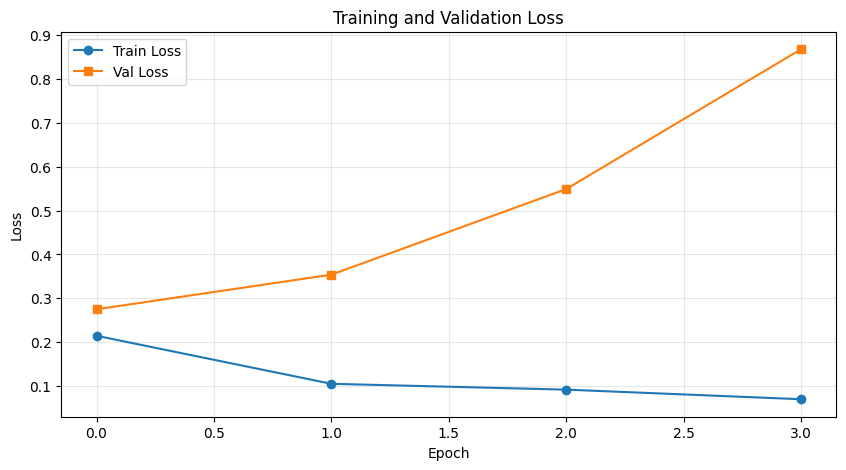

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. 评估模型

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 收集预测结果
all_preds = []
all_labels = []
all_probs = []

print("评估模型...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)

        if USE_REAL_DATASET:
            # 单标签分类
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            all_probs.append(probs[:, 1].cpu().numpy())  # 正类概率
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
        else:
            # 多标签分类
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())

# 合并结果
if USE_REAL_DATASET:
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
else:
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

# 计算指标
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary' if USE_REAL_DATASET else 'macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='binary' if USE_REAL_DATASET else 'macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='binary' if USE_REAL_DATASET else 'macro', zero_division=0)

# 计算 AUC
try:
    if USE_REAL_DATASET:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = roc_auc_score(all_labels, all_probs, average='macro')
except:
    auc = 0.0

print("\n评估结果:")
print(f"准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"AUC: {auc:.4f}")

if USE_REAL_DATASET:
    print(f"\n分类报告:")
    print(f"  正常 (Normal): {np.sum(all_labels == 0)} 张")
    print(f"  肺炎 (Pneumonia): {np.sum(all_labels == 1)} 张")
    print(f"  预测正确: {np.sum(all_preds == all_labels)} 张")
    print(f"  预测错误: {np.sum(all_preds != all_labels)} 张")

评估模型...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


评估结果:
准确率: 0.9167 (91.67%)
精确率: 0.9183
召回率: 0.9513
F1分数: 0.9345
AUC: 0.9610

分类报告:
  正常 (Normal): 234 张
  肺炎 (Pneumonia): 390 张
  预测正确: 572 张
  预测错误: 52 张


## 8.1 完整测试集评估（真实数据集）

测试集大小: 624 张
类别: ['NORMAL', 'PNEUMONIA']

正在评估...


Testing:   0%|          | 0/20 [00:00<?, ?it/s]


测试集评估结果
准确率 (Accuracy):  0.9167 (91.67%)
精确率 (Precision): 0.9183
召回率 (Recall):    0.9513
F1分数 (F1-Score):  0.9345
AUC:                0.9610

数据分布:
  正常 (Normal):    234 张
  肺炎 (Pneumonia): 390 张

预测结果:
  预测正确: 572 张
  预测错误: 52 张

混淆矩阵:
  真阴性 (TN): 201 - 正确识别为正常
  假阳性 (FP): 33 - 正常误判为肺炎
  假阴性 (FN): 19 - 肺炎误判为正常
  真阳性 (TP): 371 - 正确识别为肺炎


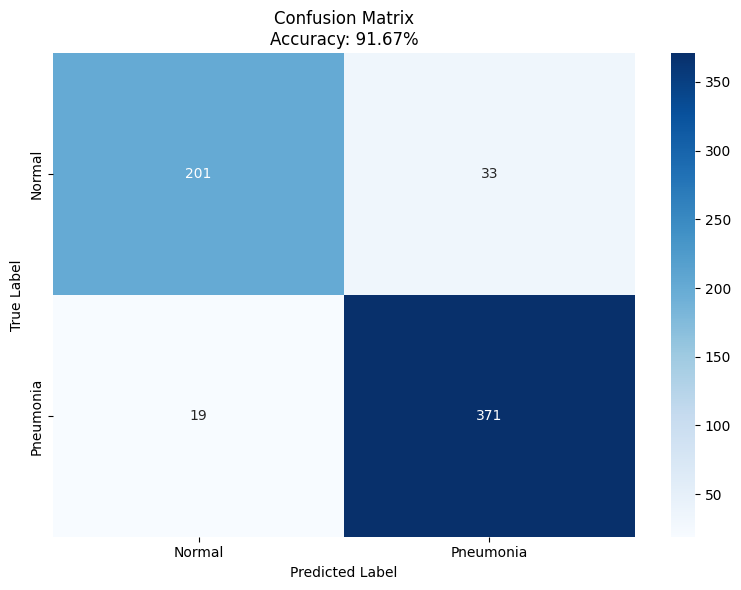

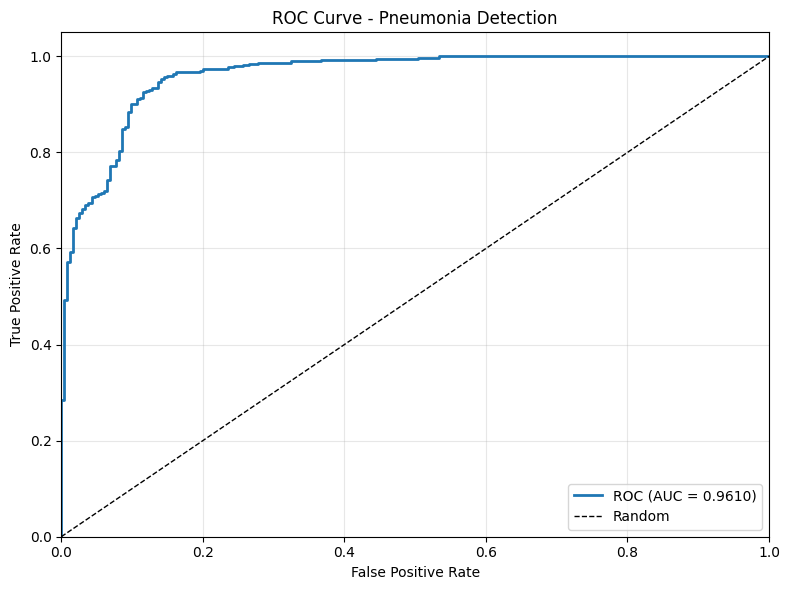


[OK] 测试集评估完成！


In [ ]:
# 使用完整测试集评估（仅真实数据集）
if USE_REAL_DATASET:
    import os
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # 加载测试集
    test_dir = config.DATA['data_dir'].replace('train', 'test')

    if os.path.exists(test_dir):
        from torchvision import datasets

        test_dataset = datasets.ImageFolder(
            root=test_dir,
            transform=get_val_transforms(config.DATA['image_size'])
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=2
        )

        print(f"测试集大小: {len(test_dataset)} 张")
        print(f"类别: {test_dataset.classes}\n")

        # 加载最佳模型
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()

        # 收集预测结果
        all_preds = []
        all_labels = []
        all_probs = []

        print("正在评估...")
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images = images.to(device)
                outputs = model(images)

                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                all_probs.append(probs[:, 1].cpu().numpy())
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.numpy())

        # 合并结果
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)

        # 计算指标
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='binary')
        recall = recall_score(all_labels, all_preds, average='binary')
        f1 = f1_score(all_labels, all_preds, average='binary')
        auc = roc_auc_score(all_labels, all_probs)

        cm = confusion_matrix(all_labels, all_preds)

        # 显示结果
        print("\n" + "="*60)
        print("测试集评估结果")
        print("="*60)
        print(f"准确率 (Accuracy):  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"精确率 (Precision): {precision:.4f}")
        print(f"召回率 (Recall):    {recall:.4f}")
        print(f"F1分数 (F1-Score):  {f1:.4f}")
        print(f"AUC:                {auc:.4f}")
        print("="*60)

        print(f"\n数据分布:")
        print(f"  正常 (Normal):    {np.sum(all_labels == 0)} 张")
        print(f"  肺炎 (Pneumonia): {np.sum(all_labels == 1)} 张")

        print(f"\n预测结果:")
        print(f"  预测正确: {np.sum(all_preds == all_labels)} 张")
        print(f"  预测错误: {np.sum(all_preds != all_labels)} 张")

        print(f"\n混淆矩阵:")
        print(f"  真阴性 (TN): {cm[0,0]} - 正确识别为正常")
        print(f"  假阳性 (FP): {cm[0,1]} - 正常误判为肺炎")
        print(f"  假阴性 (FN): {cm[1,0]} - 肺炎误判为正常")
        print(f"  真阳性 (TP): {cm[1,1]} - 正确识别为肺炎")

        # 可视化混淆矩阵
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Pneumonia'],
                    yticklabels=['Normal', 'Pneumonia'])
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # ROC 曲线
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Pneumonia Detection')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\n[OK] 测试集评估完成！")
    else:
        print(f"测试集目录不存在: {test_dir}")
else:
    print("示例数据集没有独立测试集")

## 9. 预测示例

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# 获取示例图像
sample_images = [os.path.join(config.DATA['data_dir'], f)
                 for f in os.listdir(config.DATA['data_dir'])
                 if f.endswith(('.jpg', '.png'))][:3]

class_names = train_dataset.class_names

for img_path in sample_images:
    image = Image.open(img_path).convert('RGB')

    # 预处理
    transform = get_val_transforms(config.DATA['image_size'])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 预测
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.sigmoid(output).cpu().numpy()[0]

    # 显示结果
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Input: {os.path.basename(img_path)}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, probs)
    plt.yticks(y_pos, class_names, fontsize=8)
    plt.xlabel('Probability')
    plt.title('Predictions')
    plt.xlim([0, 1])

    plt.tight_layout()
    plt.show()

    # Top-3 预测
    top3_idx = np.argsort(probs)[-3:][::-1]
    print(f"Top-3 预测:")
    for idx in top3_idx:
        print(f"  {class_names[idx]}: {probs[idx]:.2%}")
    print("\n" + "="*50 + "\n")

AttributeError: 'ImageFolder' object has no attribute 'class_names'